<a href="https://colab.research.google.com/github/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/blob/master/HAM10000_DenseNet121_FocalLoss_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Fri Feb 19 04:51:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_6classes_utils_functions_Ver2 import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [3]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 6

LR = 3e-5 # Learning rate

# Data Preparation

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/6_classes_HAM10000_split_Ver2

Cloning into '6_classes_HAM10000_split_Ver2'...
remote: Enumerating objects: 1258, done.
remote: Counting objects: 100% (1258/1258), done.
remote: Compressing objects: 100% (1253/1253), done.
remote: Total 5434 (delta 5), reused 1257 (delta 4), pack-reused 4176
Receiving objects: 100% (5434/5434), 91.95 MiB | 44.14 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [6]:
train_path = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train' 
val_path = '/content/6_classes_HAM10000_split_Ver2/images/cc_val'
test_path = '/content/6_classes_HAM10000_split_Ver2/images/cc_test'

# Data Augmentation

In [7]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = train_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = train_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None)

Found 4160 images belonging to 6 classes.
Found 896 images belonging to 6 classes.
Found 334 images belonging to 6 classes.


# Model

## Build Model

In [9]:
def build_model_DenseNet121():
  base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(average_pooling_layer)
  model = Model(inputs=base_model.input, outputs=prediction_layer)
  return model

In [10]:
model = build_model_DenseNet121()

29089792/29084464 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [12]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m 
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)

    return categorical_focal_loss_fixed

## Compile

In [13]:
model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='HAM10000_DenseNet121_FocalLoss_Ver2_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [15]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
130/130 [==============================] - ETA: 0s - batch: 64.5000 - size: 32.0000 - loss: 1.2739 - accuracy: 0.5043

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


130/130 [==============================] - 204s 1s/step - batch: 64.5000 - size: 32.0000 - loss: 1.2739 - accuracy: 0.5043 - val_loss: 1.5087 - val_accuracy: 0.3717
Epoch 2/100
130/130 [==============================] - 85s 654ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.8014 - accuracy: 0.6935 - val_loss: 1.1179 - val_accuracy: 0.5681
Epoch 3/100
130/130 [==============================] - 86s 661ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.6266 - accuracy: 0.7683 - val_loss: 1.0281 - val_accuracy: 0.6161
Epoch 4/100
130/130 [==============================] - 86s 659ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.5268 - accuracy: 0.7974 - val_loss: 0.7458 - val_accuracy: 0.7243
Epoch 5/100
130/130 [==============================] - 85s 655ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.4429 - accuracy: 0.8457 - val_loss: 0.7171 - val_accuracy: 0.7444
Epoch 6/100
130/130 [==============================] - 86s 659ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.3930 -

# Training Graph

## Accuracy

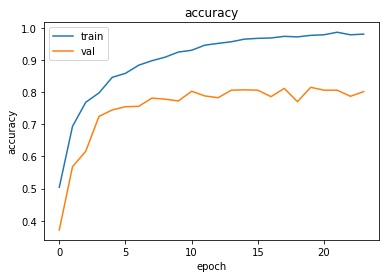

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

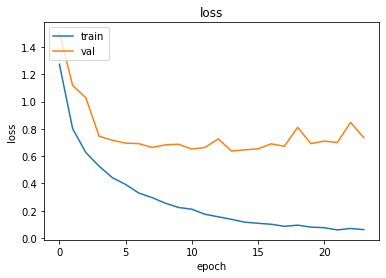

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluation

In [18]:
test_model = tf.keras.models.load_model('/content/HAM10000_DenseNet121_FocalLoss_Ver2_model.h5')

In [19]:
num_test_files = len(test_generator.filenames)

In [20]:
test_generator.reset()

In [21]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Confusion Matrix


### Without Normalize

Confusion matrix, without normalization
[[ 23   3   3   1   3   0]
 [  4  44   2   1   1   0]
 [  2   4  84   1  19   0]
 [  1   1   1   9   0   0]
 [  3   3   6   0 100   0]
 [  0   0   0   1   0  14]]


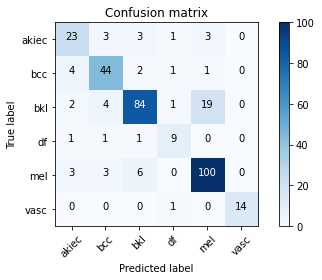

In [22]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.6969697  0.09090909 0.09090909 0.03030303 0.09090909 0.        ]
 [0.07692308 0.84615385 0.03846154 0.01923077 0.01923077 0.        ]
 [0.01818182 0.03636364 0.76363636 0.00909091 0.17272727 0.        ]
 [0.08333333 0.08333333 0.08333333 0.75       0.         0.        ]
 [0.02678571 0.02678571 0.05357143 0.         0.89285714 0.        ]
 [0.         0.         0.         0.06666667 0.         0.93333333]]


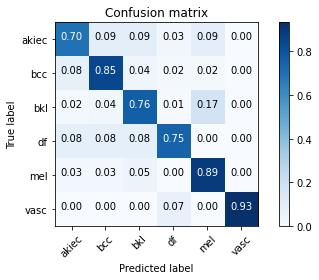

In [23]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [24]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[ 23   3   3   1   3   0]
 [  4  44   2   1   1   0]
 [  2   4  84   1  19   0]
 [  1   1   1   9   0   0]
 [  3   3   6   0 100   0]
 [  0   0   0   1   0  14]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.70      0.70      0.70        33
         bcc       0.80      0.85      0.82        52
         bkl       0.88      0.76      0.82       110
          df       0.69      0.75      0.72        12
         mel       0.81      0.89      0.85       112
        vasc       1.00      0.93      0.97        15

    accuracy                           0.82       334
   macro avg       0.81      0.81      0.81       334
weighted avg       0.82      0.82      0.82       334



## TP FP FN TN

In [25]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [26]:
TruePositive= np.diag(cm_2)

In [27]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[ 23  44  84   9 100  14]
Sum of True Positive:  274


### FP

In [28]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [29]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[10, 11, 12, 4, 23, 0]
Sum of False Positive:  60


### FN

In [30]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [31]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[10, 8, 26, 3, 12, 1]
Sum of False Negative:  60


### TN

In [32]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [33]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[291, 271, 212, 318, 199, 319]
Sum of True Negative:  1610


## Check TP + FP + FN + TN = Test set

In [34]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True
True
True
True
True


## PYCM

In [35]:
!pip3 install pycm==3.0 

     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 573kB 32.5MB/s 


In [36]:
from pycm import *

In [37]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [38]:
py_cm.classes

[0, 1, 2, 3, 4, 5]

In [39]:
py_cm.table

{0: {0: 23, 1: 3, 2: 3, 3: 1, 4: 3, 5: 0},
 1: {0: 4, 1: 44, 2: 2, 3: 1, 4: 1, 5: 0},
 2: {0: 2, 1: 4, 2: 84, 3: 1, 4: 19, 5: 0},
 3: {0: 1, 1: 1, 2: 1, 3: 9, 4: 0, 5: 0},
 4: {0: 3, 1: 3, 2: 6, 3: 0, 4: 100, 5: 0},
 5: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 14}}

In [40]:
print(py_cm)

Predict   0         1         2         3         4         5         
Actual
0         23        3         3         1         3         0         

1         4         44        2         1         1         0         

2         2         4         84        1         19        0         

3         1         1         1         9         0         0         

4         3         3         6         0         100       0         

5         0         0         0         1         0         14        





Overall Statistics : 

95% CI                                                            (0.77919,0.86153)
ACC Macro                                                         0.94012
ARI                                                               0.59755
AUNP                                                              0.87909
AUNU                                                              0.88676
Bangdiwala B                                                      0.69101
Bennett S

### Average AUC

In [41]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1] + py_cm.AUC[2] + py_cm.AUC[3] + py_cm.AUC[4] + py_cm.AUC[5])/len(py_cm.AUC)

In [42]:
print('Average AUC: ', AV_AUC)

Average AUC:  0.8867602755805164


### Average Sensitivity

In [43]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1] + py_cm.TPR[2] + py_cm.TPR[3] + py_cm.TPR[4] + py_cm.TPR[5])/len(py_cm.TPR)

In [44]:
print('Average Sensitivity: ', AV_Sens)

Average Sensitivity:  0.8138250638250638


### Average Specificity

In [45]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1] + py_cm.TNR[2] + py_cm.TNR[3] + py_cm.TNR[4] + py_cm.TNR[5])/len(py_cm.TNR)

In [46]:
print('Average Specificity: ', AV_Spec)

Average Specificity:  0.9596954873359689


## Grad-CAM

In [47]:
last_conv2d = 'conv5_block16_2_conv'

### AKIEC

In [48]:
akiec_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/akiec/ISIC_0026492.jpg' 

Model prediction:
	mel            	(4)	with probability 0.909
	akiec          	(0)	with probability 0.058
	bcc            	(1)	with probability 0.015
	bkl            	(2)	with probability 0.014
	df             	(3)	with probability 0.003
Explanation for 'mel'


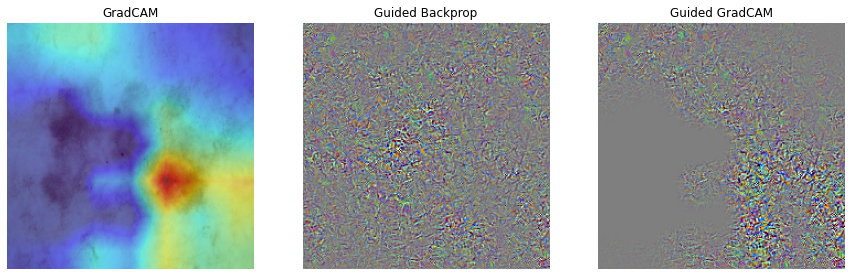

In [49]:
 gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

### BCC

In [50]:
bcc_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bcc/ISIC_0024332.jpg'

Model prediction:
	bcc            	(1)	with probability 0.996
	mel            	(4)	with probability 0.003
	akiec          	(0)	with probability 0.001
	bkl            	(2)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'bcc'


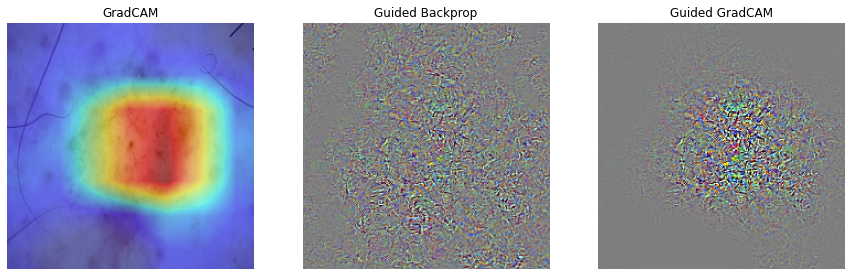

In [51]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bcc_img, layer_name=last_conv2d)

### BKL

In [52]:
bkl_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.965
	bkl            	(2)	with probability 0.028
	akiec          	(0)	with probability 0.006
	bcc            	(1)	with probability 0.001
	vasc           	(5)	with probability 0.000
Explanation for 'mel'


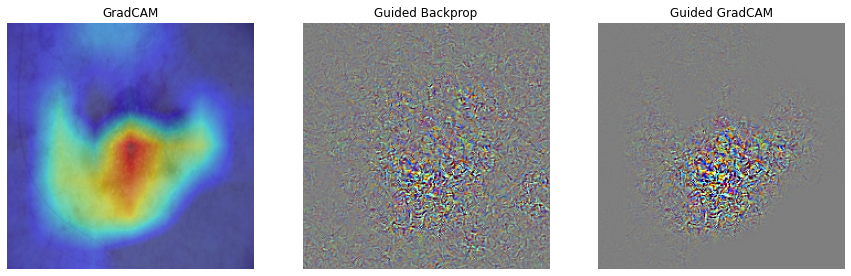

In [53]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bkl_img, layer_name=last_conv2d)

### DF

In [54]:
df_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_val/df/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.547
	df             	(3)	with probability 0.444
	bcc            	(1)	with probability 0.009
	bkl            	(2)	with probability 0.000
	vasc           	(5)	with probability 0.000
Explanation for 'mel'


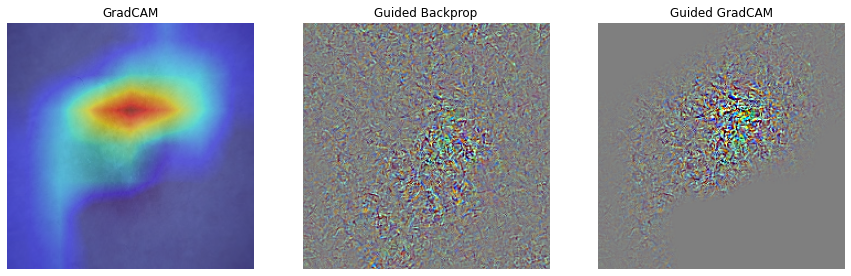

In [55]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, df_img, layer_name=last_conv2d)

### MEL

In [56]:
mel_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 1.000
	akiec          	(0)	with probability 0.000
	bcc            	(1)	with probability 0.000
	bkl            	(2)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'mel'


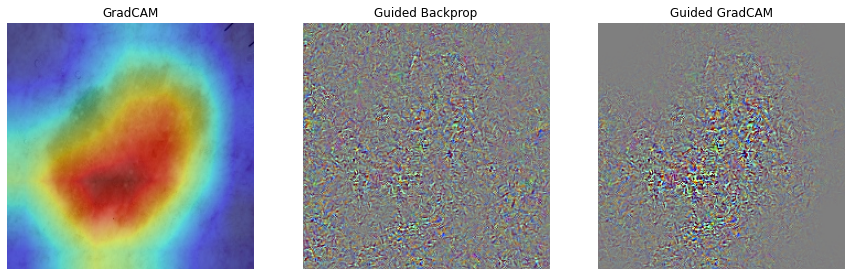

In [57]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, mel_img, layer_name=last_conv2d)

### VASC

In [58]:
vasc_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_test/vasc/ISIC_0025452.jpg'

Model prediction:
	vasc           	(5)	with probability 0.999
	mel            	(4)	with probability 0.001
	bkl            	(2)	with probability 0.000
	akiec          	(0)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'vasc'


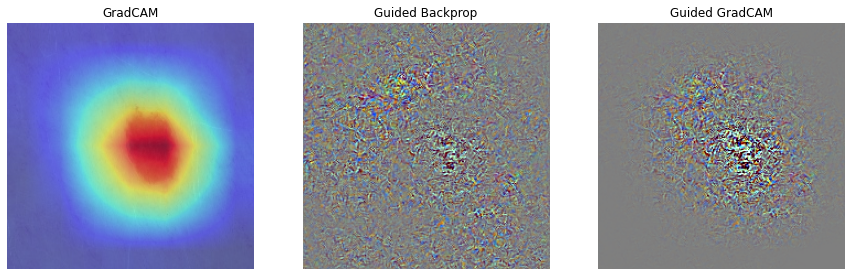

In [59]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, vasc_img, layer_name=last_conv2d)

# Download Model

In [60]:
from google.colab import files

In [61]:
files.download('/content/HAM10000_DenseNet121_FocalLoss_Ver2_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>